In [1]:
import torch
import numpy as np
import os
import torch.nn as nn
import torch.nn.functional as F
import PIL
import matplotlib.pyplot as plt
from torchvision import transforms
import torch.optim as optim
from tqdm import tqdm


In [4]:
print(torch.cuda.is_available())

True


In [5]:
path=r'/home/artemybombastic/ArtemyBombasticNotebooks/Datasets/images'
class AnimeDataset(torch.utils.data.Dataset):
    def __init__(self,path):
        super(AnimeDataset,self).__init__()
        self.all_images=[os.path.join(path,img_name) for img_name in os.listdir(path)]
        self.transformer=transforms.Compose([
            transforms.Resize((256,256)),
            transforms.ToTensor()
        ])
    def __len__(self):
        return len(self.all_images)
    def __getitem__(self,idx):
        img=PIL.Image.open(self.all_images[idx])

        tensor_img=self.transformer(img)
        return tensor_img

In [6]:
Data=AnimeDataset(path)

In [7]:
len(Data)

63565

In [8]:
Data[5]

tensor([[[0.6196, 0.6157, 0.5882,  ..., 1.0000, 1.0000, 1.0000],
         [0.6157, 0.6118, 0.5843,  ..., 1.0000, 1.0000, 1.0000],
         [0.5882, 0.5843, 0.5529,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [0.7216, 0.7176, 0.7020,  ..., 1.0000, 1.0000, 1.0000],
         [0.7333, 0.7294, 0.6941,  ..., 1.0000, 1.0000, 1.0000],
         [0.7373, 0.7333, 0.6941,  ..., 1.0000, 1.0000, 1.0000]],

        [[0.3529, 0.3490, 0.3176,  ..., 0.9961, 0.9961, 0.9961],
         [0.3490, 0.3451, 0.3137,  ..., 0.9961, 0.9961, 0.9961],
         [0.3216, 0.3176, 0.2824,  ..., 0.9961, 0.9961, 0.9961],
         ...,
         [0.4353, 0.4275, 0.4118,  ..., 1.0000, 1.0000, 1.0000],
         [0.4471, 0.4392, 0.4000,  ..., 1.0000, 1.0000, 1.0000],
         [0.4471, 0.4392, 0.4000,  ..., 1.0000, 1.0000, 1.0000]],

        [[0.3020, 0.2980, 0.2706,  ..., 1.0000, 1.0000, 1.0000],
         [0.2980, 0.2941, 0.2667,  ..., 1.0000, 1.0000, 1.0000],
         [0.2745, 0.2706, 0.2353,  ..., 1.0000, 1.0000, 1.

In [9]:
loader=torch.utils.data.DataLoader(Data, batch_size=16,shuffle=True,drop_last=True)

In [10]:
class Map_Linear(nn.Module):#не моя версия:
    def __init__(self,input_size,ouptut_size):
        super(Map_Linear,self).__init__()

        self.linear=nn.Linear(input_size,ouptut_size,bias=True)
        self.scale=(2/input_size)**0.5
        self.bias=self.linear.bias
        self.linear.bias=None

        nn.init.normal_(self.linear.weight)
        nn.init.zeros_(self.bias)

    def forward(self,x):
        return self.linear(x*self.scale)+self.bias

In [11]:
class PixelNorm(nn.Module):
    def __init__(self):
        super(PixelNorm, self).__init__()
        self.epsilon = 1e-8
    def forward(self, x):
        return x / torch.sqrt(torch.mean(x ** 2, dim=1, keepdim=True) + self.epsilon)

In [12]:
class Map_Net(nn.Module):
    def __init__(self,z_size,w_size):
        super().__init__()
        self.relu=nn.ReLU(0.2)
        self.pix=PixelNorm()
        
        self.ML0=Map_Linear(z_size,w_size)
        self.ML1=Map_Linear(w_size,w_size)
        self.ML2=Map_Linear(w_size,w_size)
        self.ML3=Map_Linear(w_size,w_size)
        self.ML4=Map_Linear(w_size,w_size)
        self.ML5=Map_Linear(w_size,w_size)
        self.ML6=Map_Linear(w_size,w_size)
        self.ML7=Map_Linear(w_size,w_size)
        
    def forward(self,x):
        
        x=self.pix(x)
        x0=self.relu(self.ML0(x))
        x1=self.relu(self.ML0(x0))
        x2=self.relu(self.ML0(x1))
        x3=self.relu(self.ML0(x2))
        x4=self.relu(self.ML0(x3))
        x5=self.relu(self.ML0(x4))
        x6=self.relu(self.ML0(x5))
        x7=self.ML0(x6)

        return x7

In [13]:
class AdaIN(nn.Module):
    def __init__(self,w_dim,chanels):
        super().__init__()
        self.instance=nn.InstanceNorm2d(chanels)
        self.style_scale=Map_Linear(w_dim,chanels)
        self.style_bias=Map_Linear(w_dim,chanels)
    def forward(self,x,w):

    
        x=self.instance(x)
        style_scale=self.style_scale(w).unsqueeze(2).unsqueeze(3) #unsqeeze добавить позже
        style_bias=self.style_bias(w).unsqueeze(2).unsqueeze(3)   #unsqeeze добавить позже
        return style_scale *x + style_bias

In [14]:
class NoiseGenerator(nn.Module):
    def __init__(self,channels):
        super().__init__()
        self.weigh=nn.Parameter(torch.zeros(1,channels,1,1))
    def forward(self,x):
        noise=torch.rand((x.shape[0],1,x.shape[2],x.shape[3]),device=x.device)
        return x+self.weigh*noise
        

In [15]:
class WSConv2d(nn.Module):#не моя версия, я бы убрал взвешивание
    def __init__(self,input_size,ouptut_size,kernel_size=3,stride=1,padding=1):
        super(WSConv2d,self).__init__()
        
        self.conv=nn.Conv2d(input_size,ouptut_size,kernel_size,stride,padding)
        self.scale=(2/(input_size*(kernel_size**2)))**0.5
        self.bias=self.conv.bias
        self.conv.bias=None

        nn.init.normal_(self.conv.weight)
        nn.init.zeros_(self.bias)

    def forward(self,x):
        #print((x*self.scale).shape)
        return self.conv(x*self.scale)+self.bias.view(1, self.bias.shape[0], 1, 1)
        
        

In [16]:
class GenBlock(nn.Module):
    def __init__(self,input_size,output_size,w_dim):
        super(GenBlock,self).__init__()

        self.conv0=WSConv2d(input_size,output_size)
        self.conv1=WSConv2d(output_size,output_size)

        self.leaky=nn.LeakyReLU(0.2)
        self.noise0=NoiseGenerator(output_size)
        self.noise1=NoiseGenerator(output_size)

        self.ada0=AdaIN(chanels=output_size,w_dim=w_dim)
        self.ada1=AdaIN(chanels=output_size,w_dim=w_dim)

    def forward(self,x,w):
        x=self.ada0(self.leaky(self.noise0(self.conv0(x))),w)
        x=self.ada1(self.leaky(self.noise1(self.conv1(x))),w)
        return x

        

In [17]:
factors=[1, 1, 1, 1, 1 / 2, 1 / 4, 1 / 8, 1 / 16, 1 / 32]

In [18]:
class Generator(nn.Module):
    def __init__(self,z_dim,w_dim,in_channels,img_channels=3):
        super(Generator,self).__init__()
        self.const=nn.Parameter(torch.ones((1,in_channels,4,4)))#делаем константу обучаемой
        self.after_mapping=Map_Net(z_dim,w_dim)
        self.initial_ada0=AdaIN(in_channels,w_dim)
        self.initial_ada1=AdaIN(in_channels,w_dim)
        self.initial_noise0=NoiseGenerator(in_channels)
        self.initial_noise1=NoiseGenerator(in_channels)
        self.initial_conv=nn.Conv2d(in_channels,in_channels,kernel_size=3,stride=1,padding=1)
        self.leaky=nn.LeakyReLU(0.2,inplace=True)

        self.initial_rgb=WSConv2d( #Начальный конв
            in_channels,img_channels,kernel_size=1,stride=1,padding=0
        )

        self.prog_blocks=nn.ModuleList([])
        self.rgb_layers=nn.ModuleList([self.initial_rgb])
        
        for i in range(len(factors)-1):
            conv_in=int(in_channels*factors[i])
            conv_out=int(in_channels*factors[i+1])
            self.prog_blocks.append(GenBlock(input_size=conv_in,output_size=conv_out,w_dim=w_dim))
            self.rgb_layers.append(WSConv2d(conv_out,img_channels,kernel_size=1,stride=1,padding=0))

    def fade_in(self,alpha,upscales,generated):
        return torch.tanh(alpha*generated+(1-alpha)*upscales)

    def forward(self,noise,alpha,steps):
        w=self.after_mapping(noise)
        x=self.initial_ada0(self.initial_noise0(self.const),w)
        x=self.initial_conv(x)  
        out=self.initial_ada1(self.leaky(self.initial_noise1(x)),w)
        if steps==0:
            return self.initial_rgb(x)
        for step in range(steps):
            upscaled=F.interpolate(out,scale_factor=2,mode='bilinear')
            out=self.prog_blocks[step](upscaled,w)
      
        #return self.rgb_layers
        final_ups=self.rgb_layers[steps-1](upscaled)
        final_out=self.rgb_layers[steps](out)
        return self.fade_in(alpha,final_ups,final_out)
            
        

In [19]:
class DiscConvBlock(nn.Module):
    def __init__(self,input_size,output_size):
        super(DiscConvBlock,self).__init__()

        self.conv0=WSConv2d(input_size,output_size)
        self.conv1=WSConv2d(output_size,output_size)
        self.act=nn.LeakyReLU(0.2)
    def forward(self,x):
        x=self.act(self.conv0(x))
        x=self.act(self.conv1(x))
        return x

In [20]:
class Discriminator(nn.Module):
    def __init__(self,in_channels,img_chanels=3):
        super(Discriminator,self).__init__()
        self.prog_blocks=nn.ModuleList([])
        self.rgb_layers=nn.ModuleList([])
        self.leaky=nn.LeakyReLU(0.2)
        for i in range(len(factors)-1,0,-1):
            conv_in=int(in_channels*factors[i])
            conv_out=int(in_channels*factors[i-1])
            self.prog_blocks.append(DiscConvBlock(conv_in,conv_out))
            self.rgb_layers.append(WSConv2d(img_chanels,conv_in,kernel_size=1,stride=1,padding=0))

        self.initial_rgb=WSConv2d(img_chanels,in_channels,kernel_size=1,stride=1,padding=0)

        self.rgb_layers.append(self.initial_rgb)
        self.avg_pool=nn.AvgPool2d(
            kernel_size=2, stride=2
        )
        self.final_block=nn.Sequential(
            WSConv2d(in_channels+1,in_channels,kernel_size=3,padding=1),
            nn.LeakyReLU(0.2),
            WSConv2d(in_channels,in_channels,kernel_size=4,padding=0,stride=1),
            nn.LeakyReLU(0.2),
            WSConv2d(in_channels,1,kernel_size=1,padding=0,stride=1),
            nn.Sigmoid()
            
        )
    def fade_in (self,alpha,downscaled,out):
        return alpha*out + (1-alpha)*downscaled

    def minibatch_std(self,x):
        batch_statistics=(
            torch.std(x,dim=0).mean().repeat(x.shape[0],1,x.shape[2],x.shape[3])
        )
        return torch.cat([x,batch_statistics],dim=1)

    def forward(self,x,alpha,steps):
        cur_step=len(self.prog_blocks)-steps

        out = self.leaky(self.rgb_layers[cur_step](x))

        if steps==0:
            out=self.minibatch_std(x)
            return self.final_block(out).view(out.shape[0],-1)
            
        downscaled=self.leaky(self.rgb_layers[cur_step+1](self.avg_pool(x)))      
        out=self.avg_pool(self.prog_blocks[cur_step](out))
        
        out=self.fade_in(alpha,downscaled,out)

        for step in range(cur_step+1,len(self.prog_blocks)):
            out=self.prog_blocks[step](out)
            out=self.avg_pool(out)
        out=self.minibatch_std(out)
        return self.final_block(out).view(out.shape[0],-1)
        
        

            

In [21]:
DATASET                 = "Women clothes"
START_TRAIN_AT_IMG_SIZE = 8 #The authors start from 8x8 images instead of 4x4
DEVICE                  = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE           = 1e-3
BATCH_SIZES             = [256, 128, 64, 32, 16, 8]
CHANNELS_IMG            = 3
Z_DIM                   = 256
W_DIM                   = 256
IN_CHANNELS             = 256
LAMBDA_GP               = 10
PROGRESSIVE_EPOCHS      = [30] * len(BATCH_SIZES)

In [22]:
gen_model=Generator(256,256,256).to(DEVICE)
#gen_model=Generator(256,256,256)
disc_model=Discriminator(256).to(DEVICE)
#disc_model=Discriminator(256)

In [23]:
# noise=torch.randn(16,256).to(DEVICE)
# fake=gen_model(noise,1e-5,6)

In [24]:
# a=disc_model(fake,1e-5,6)

In [25]:
# a.shape

In [26]:
# plt.imshow(fake[0].detach().cpu().numpy().transpose(1,2,0))

In [27]:
torch.cuda.empty_cache()

In [28]:
import gc
#del variables
gc.collect()

741

In [29]:
gen_optim= optim.Adam([{"params": [param for name, param in gen_model.named_parameters() if "map" not in name]},
                                {"params": gen_model.after_mapping.parameters(), "lr": 1e-5}], lr=LEARNING_RATE, betas=(0.0, 0.99))
gen_loss_func=nn.BCELoss()

disc_optim=optim.Adam(disc_model.parameters(),lr=LEARNING_RATE,betas=(0.0,0.99))
disc_loss_func=nn.BCELoss()

In [30]:
gen_optim

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.0, 0.99)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0

Parameter Group 1
    amsgrad: False
    betas: (0.0, 0.99)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 1e-05
    maximize: False
    weight_decay: 0
)

In [31]:
state_dict=torch.load('StyleGanGeneratorWeights.pth',weights_only=True)
gen_model.load_state_dict(state_dict)

FileNotFoundError: [Errno 2] No such file or directory: 'StyleGanGeneratorWeights.pth'

In [30]:
state_dict=torch.load('StyleGanDiscriminatorWeights.pth',weights_only=True)
disc_model.load_state_dict(state_dict)

<All keys matched successfully>

In [31]:

alpha=1e-5
steps=6

for batch in (pbar:= tqdm(loader)):
    disc_optim.zero_grad()
    noise=torch.randn(16,256).to(DEVICE)
    
    real_images=batch.to(DEVICE)
    #real_images=batch
    fake_images=gen_model(noise,alpha,steps)

    #обучаем дискриминатор
    real_pred=disc_model(real_images,alpha,steps)
    fake_pred=disc_model(fake_images,alpha,steps)

    disc_real_loss=disc_loss_func(real_pred,torch.ones(16,1).to(DEVICE))
    disc_fake_loss=disc_loss_func(fake_pred,torch.zeros(16,1).to(DEVICE))
    disc_loss=disc_real_loss+disc_fake_loss
    #print(disc_loss.item())
    disc_loss_item=disc_loss.item()
    disc_loss.backward()
    disc_optim.step()

    #обучаем генератор
    gen_optim.zero_grad()
    noise=torch.randn(16,256).to(DEVICE)
    gen_images=gen_model(noise,alpha,steps)
    gen_ac=disc_model(gen_images,alpha,steps)
    gen_loss=gen_loss_func(gen_ac,torch.ones(16,1).to(DEVICE))
    gen_loss.backward()
    gen_loss_item=gen_loss.item()
    gen_optim.step()
    pbar.set_description(f'disc_loss:{disc_loss_item},gen_loss:{gen_loss_item}')
    print(f'disc_loss:{disc_loss_item},gen_loss:{gen_loss_item}')
    
    
    
   
    
    

disc_loss:0.07064391672611237,gen_loss:4.579022407531738:   0%|                     | 1/1346 [00:14<5:30:01, 14.72s/it]

disc_loss:0.07064391672611237,gen_loss:4.579022407531738


disc_loss:0.07064391672611237,gen_loss:4.579022407531738:   0%|                     | 1/1346 [00:16<6:16:10, 16.78s/it]


KeyboardInterrupt: 

In [43]:
# import os

# os.environ['CUDA_LAUNCH_BLOCKING']="1"
# os.environ['TORCH_USE_CUDA_DSA'] = "1"

In [32]:
torch.save(gen_model.state_dict(),'StyleGanGeneratorWeights.pth')

In [33]:
torch.save(disc_model.state_dict(),'StyleGanDiscriminatorWeights.pth')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


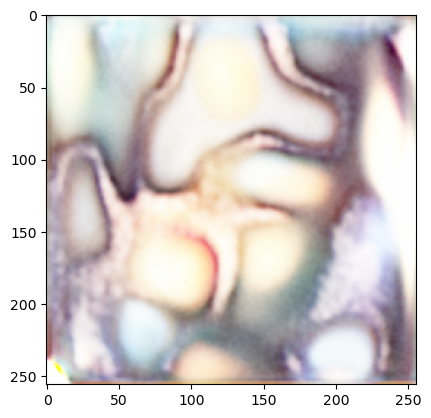

In [34]:
noise=torch.randn(16,256).to(DEVICE)
fake=gen_model(noise,1e-5,6)
plt.imshow(fake[0].detach().cpu().numpy().transpose(1,2,0))